##### Copyright 2018 The TensorFlow Authors.

In [ ]:
import pickle
import numpy as np
import os
import gzip
import torch


def read_data(datasets_dir="./data", frac = 0.1):
    """
    This method reads the states and actions recorded in drive_manually.py 
    and splits it into training/ validation set.
    """
    print("... read data")

    #combines the paths
    data_file = os.path.join(datasets_dir, 'data.pkl.gzip')

    f = gzip.open(data_file,'rb')
    data = pickle.load(f)

    # get images as features and actions as targets
    X = np.array(data["state"]).astype('float32')
    y = np.array(data["action"]).astype('float32')

    # split data into training and validation set
    n_samples = len(data["state"])
    X_train, y_train = X[:int((1-frac) * n_samples)], y[:int((1-frac) * n_samples)]
    X_valid, y_valid = X[int((1-frac) * n_samples):], y[int((1-frac) * n_samples):]
    return X_train, y_train, X_valid, y_valid


def preprocessing(X_train, y_train, X_valid, y_valid, history_length=1):

    # crop, 84 x 84, some pixels never change
    X_train = np.array([img[:-12,6:-6] for img in X_train])
    X_valid = np.array([img[:-12,6:-6] for img in X_valid])
    # grayscale
    X_train = np.array([np.dot(img[...,0:3], [0.299, 0.587, 0.114]) for img in X_train])
    X_valid = np.array([np.dot(img[...,0:3], [0.299, 0.587, 0.114]) for img in X_valid])
    # scaling/normalizing
    X_train = np.array([img/255.0 for img in X_train])
    X_valid = np.array([img/255.0 for img in X_valid])
    
    return X_train, y_train, X_valid, y_valid



In [ ]:
X_train, y_train, X_valid, y_valid = read_data(".")

... read data


In [ ]:
X_train.shape

(18000, 96, 96, 3)

In [ ]:
y_train.shape

(18000, 3)

In [ ]:
X_train, y_train, X_valid, y_valid = preprocessing(X_train, y_train, X_valid, y_valid)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(18000, 84, 84)
(18000, 3)


In [ ]:
print(X_valid.shape)
print(y_train.shape)

(2000, 84, 84)
(18000, 3)


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

model = tf.keras.Sequential([
    #reshaping size to (84, 84, 1) from (84, 84)
    tf.keras.layers.Reshape(target_shape = (84, 84, 1), input_shape=(84, 84)),

    #Convolves kernels to produce a 2d activation map
    tf.keras.layers.Conv2D(4, kernel_size=(11, 11), padding="same", activation=None),

    #takes maximum out of 3x3 going by 1x1 stride
    #padding ='valid' output shape = math.floor((input_shape - pool_size) / strides) + 1
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='valid', data_format=None),
    
    tf.keras.layers.Conv2D(8, kernel_size = (5, 5), strides = (1, 1), padding='same', activation=None),
    
    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='valid', data_format=None),
    
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding='same', activation=None),
    
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding='same', activation=None),
    
    tf.keras.layers.Conv2D(8, kernel_size = (3, 3), strides = (1, 1), padding='same', activation=None),

    tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(5, 5), padding='same', data_format=None),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='linear')
    
])

2.7.0


In [ ]:
#TODO. check the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 84, 84, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 84, 84, 4)         488       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 82, 82, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 8)         808       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 80, 80, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 64)        4

In [ ]:
preds = model.predict_on_batch(X_train[:10])
print(preds.shape)
preds

(10, 3)


array([[ 8.8416953e-03,  3.4655910e-05,  2.6830547e-03],
       [-1.2142794e-02, -4.6525337e-04,  2.3752177e-02],
       [-4.6728499e-02, -3.5096522e-02,  3.0322487e-02],
       [-4.6708323e-02, -3.7717719e-02,  6.3959025e-03],
       [-3.9455526e-02, -1.0005561e-02, -1.9140989e-03],
       [-3.5342917e-02,  8.8042459e-03,  3.1076483e-02],
       [-5.4656401e-02,  8.1909541e-03,  4.1281670e-02],
       [-4.5287117e-02,  2.0397022e-02,  5.3111423e-02],
       [-3.5507567e-02,  2.6629854e-02,  6.7972049e-02],
       [-4.3832388e-02,  3.6849476e-02,  7.1537390e-02]], dtype=float32)


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

In [ ]:

history = model.fit(
    x=X_train[:9000],
    y=y_train[:9000],
    batch_size=32,
    epochs=30,
    validation_data=(X_valid, y_valid)
)

Epoch 1/30
282/282 [==============================] - 8s 27ms/step - loss: 0.0072 - mae: 0.0272 - val_loss: 0.0941 - val_mae: 0.1190
Epoch 2/30
282/282 [==============================] - 7s 26ms/step - loss: 0.0086 - mae: 0.0301 - val_loss: 0.0829 - val_mae: 0.1100
Epoch 3/30
282/282 [==============================] - 7s 26ms/step - loss: 0.0056 - mae: 0.0239 - val_loss: 0.0982 - val_mae: 0.1226
Epoch 4/30
282/282 [==============================] - 8s 27ms/step - loss: 0.0059 - mae: 0.0241 - val_loss: 0.0866 - val_mae: 0.1079
Epoch 5/30
282/282 [==============================] - 7s 27ms/step - loss: 0.0052 - mae: 0.0213 - val_loss: 0.0944 - val_mae: 0.1160
Epoch 6/30
282/282 [==============================] - 8s 27ms/step - loss: 0.0062 - mae: 0.0236 - val_loss: 0.0831 - val_mae: 0.1063
Epoch 7/30
282/282 [==============================] - 8s 27ms/step - loss: 0.0055 - mae: 0.0214 - val_loss: 0.0834 - val_mae: 0.1100
Epoch 8/30
282/282 [==============================] - 8s 27ms/step - 

In [ ]:
import pickle
model.save("modeltest30.h5")
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [ ]:
import pickle
with open("./model_30_history.pickle", "wb") as f:
  pickle.dump(model.history.history, f)

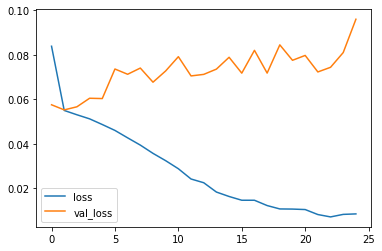

In [ ]:
import matplotlib.pyplot as plt
history.history.keys()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()




In [ ]:
print (tf.__version__)

2.7.0


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.